In [1]:
!nvidia-smi

Thu Oct  3 10:21:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   55C    P2    52W / 200W |    185MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   37C    P8    14W / 200W |    185MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import DenseNetFC, TFModel
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, plot_loss
from seismiqb.batchflow import FilesIndex, Batch, action, inbatch_parallel
from seismiqb.batchflow.batch_image import transform_actions # pylint: disable=no-name-in-module,import-error
from seismiqb.src.utils import create_mask, aggregate, make_labels_dict, _get_horizons

from utils import *

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Load cube

In [4]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

In [5]:
ds = ds.load()

## Load pretrained model

In [6]:
train_pipeline = (Pipeline()
                     .load_model('dynamic', TFModel, 'extension', path='./weighted_dice_r_cube/') << ds)
train_pipeline.next_batch(1)
train_pipeline.get_model_by_name('extension')

INFO:tensorflow:Restoring parameters from ./weighted_dice_r_cube/model-2001


In [7]:
p_start_points = [1709, 1253, 527]

## Load initial label to start expansion procedure:

In [8]:
ds.labels[ds.indices[0]][(1709 + ds.geometries[ds.indices[0]].ilines_offset, ds.geometries[ds.indices[0]].xlines_offset)]

array([1160,  561,  904, 1182, 1182])

hey you


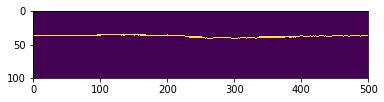

In [9]:
ds.subset_labels(p_start_points, crop_shape=[500, 500, 100], cube_index=0, show_prior_mask=True)

In [10]:
len(ds.prior_mask[ds.indices[0]])

250000

### Show current labels from above:

len  250000


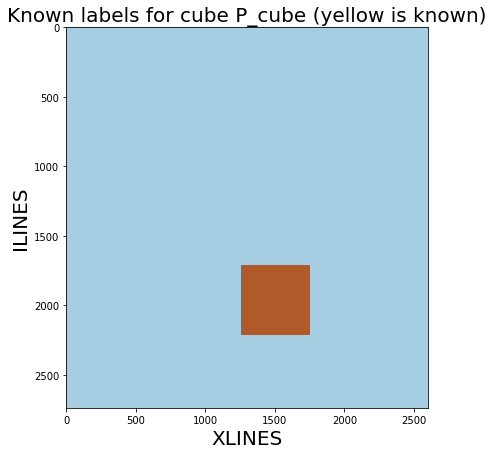

In [11]:
img = ds.show_labels(return_image=True, src='prior_mask')

In [12]:
from skimage.segmentation import find_boundaries

## Find borders

In [13]:
boundaries = find_boundaries(img).astype(np.int32)

In [14]:
np.unique(boundaries)

array([0, 1], dtype=int32)

In [15]:
border_coords = np.where(boundaries == 1)

In [16]:
np.min(border_coords[0])

1708

In [17]:
(border_coords[1][0])

1253

In [18]:
(border_coords[0][0])

1708

In [19]:
iline = 1710
x_min = 1254
x_max = 1300

In [20]:
# def make_border_grid(ds, idx, crop_shape, labels_img, stride=10):
#     borders_img = find_boundaries(img).astype(np.int32)
#     cube_name = ds.indices[idx]
#     il_len, x_len = labels_img.shape
#     border_coords = np.where(borders_img == 1)
#     il_min, il_max = np.min(border_coords[0]), np.max(border_coords[0])
#     x_min, x_max = np.min(border_coords[1]), np.max(border_coords[1])
#     il_offset = ds.geometries[ds.indices[idx]].ilines_offset
#     xl_offset = ds.geometries[ds.indices[idx]].xlines_offset

#     line_shape, height = crop_shape[1:]
#     iline_crops = []

#     # sample horizontal border points
#     for xline in range(x_min, x_max):
#         non_zero = np.where(borders_img[il_min:il_max, xline] == 1)[0]
#         _lower_il, _upper_il = np.min(non_zero) + il_min, np.max(non_zero) + il_min
#         _lower_h = ds.labels[cube_name][(_lower_il + il_offset, xline + xl_offset)] - height // 2
#         _upper_h = ds.labels[cube_name][(_upper_il + il_offset, xline + xl_offset)] - height // 2

#         _lower_il = _lower_il + stride - line_shape
#         _upper_il = _upper_il - stride
#         iline_crops.append([cube_name, _lower_il, xline, _lower_h])
#         iline_crops.append([cube_name, _upper_il, xline, _upper_h])
#     iline_crops = np.array(iline_crops, dtype=object)

#     xline_crops = []
#     # sample vertical border points
#     for iline in range(il_min, il_max):
#         non_zero = np.where(borders_img[iline, x_min:x_max] == 1)[0]
#         _lower_xl, _upper_xl = np.min(non_zero) + x_min, np.max(non_zero) + x_min
#         _lower_h = ds.labels[cube_name][(iline + il_offset, _lower_xl + xl_offset)] - height // 2
#         _upper_h = ds.labels[cube_name][(iline + il_offset, _upper_xl + xl_offset)] - height // 2

#         _lower_xl = _lower_xl + stride - line_shape
#         _upper_xl = _upper_xl - stride
#         xline_crops.append([cube_name, iline, _lower_xl, _lower_h])
#         xline_crops.append([cube_name, iline, _upper_xl, _upper_h])
#     xline_crops = np.array(xline_crops, dtype=object)
#     return iline_crops, xline_crops

# Create points generator crossing current border

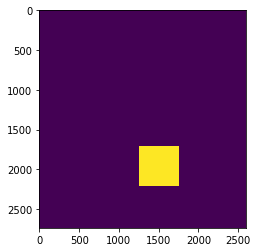

In [21]:
plt.imshow(img)

In [ ]:
ds = ds.make_expand_grid(ds.indices[0], crop_shape=(4, 100, 100),
                            labels_img=img, labels_idx=1)

print('Shape of ilines grid:', ds.iline_crops_info['grid_array'].shape)
print('Shape of xlines grid:', ds.xline_crops_info['grid_array'].shape)

In [23]:
ds.xline_crops_info['predict_shape']

(504, 680, 114)

In [24]:
axes = (1, 0, 2)

In [25]:
model_pipeline = train_pipeline

In [26]:
CUBE_SHAPE = (ds.geometries[ds.indices[0]].ilines_len, ds.geometries[ds.indices[0]].xlines_len, ds.geometries[ds.indices[0]].depth)
CUBE_SHAPE

(2737, 2599, 2001)

In [27]:
def aggregate(array_crops, array_grid, crop_shape, predict_shape, order):
    """ Jit-accelerated function to glue together crops according to grid.
    At positions, where different crops overlap, only the maximum value is saved.
    This function is usually called inside SeismicCropBatch's method `assemble_crops`.
    """
    #pylint: disable=assignment-from-no-return
    total = len(array_grid)
    background = np.zeros(predict_shape)

    for i in range(total):
        print('iii', i)
        if i > len(array_crops) - 1:
            print('endl')
            break
        il, xl, h = array_grid[i, :]
        il_end = min(background.shape[0], il+crop_shape[0])
        xl_end = min(background.shape[1], xl+crop_shape[1])
        h_end = min(background.shape[2], h+crop_shape[2])
        crop = np.transpose(array_crops[i], order)
        crop = crop[:(il_end-il), :(xl_end-xl), :(h_end-h)]
        previous = background[il:il_end, xl:xl_end, h:h_end]
        background[il:il_end, xl:xl_end, h:h_end] = np.maximum(crop, previous)
    return background

In [28]:
class TMPSeismicCropBatch(SeismicCropBatch):
    @action
    @inbatch_parallel(init='run_once')
    def assemble_crops(self, src, dst, grid_info, order=None):
        """ Glue crops together in accordance to the grid.

        Notes
        -----
        In order to use this action you must first call `make_grid` method of SeismicCubeset.
        Parameters
        ----------
        src : array-like
            Sequence of crops.
        dst : str
            Component of batch to put results in.
        grid_info : dict
            Dictionary with information about grid. Should be created by `make_grid` method.
        Returns
        -------
        SeismicCropBatch
            Batch with assembled subcube in desired component.
        """
        # Do nothing until there is a crop for every point
#         if len(src) != len(grid_info['grid_array']):
#             return self

        order = order or (2, 0, 1)
        # Since we know that cube is 3-d entity, we can get rid of
        # unneccessary dimensions
        src = np.array(src)
        src = src if len(src.shape) == 4 else np.squeeze(src, axis=-1)
        assembled = aggregate(src, grid_info['grid_array'], grid_info['crop_shape'],
                              grid_info['predict_shape'], order)
        setattr(self, dst, assembled)
        return self

In [29]:
ds.batch_class = TMPSeismicCropBatch

In [30]:
crop_shape=(100, 4, 100)

In [31]:
crop_shape=(4, 100, 100)

In [32]:
pred_pipeline = (Pipeline()
                 .load_component(src=[D('geometries'), D('labels')],
                                 dst=['geometries', 'labels'])
                 .add_components('predicted_labels')
                 .crop(points=L(D('xline_crops_gen')),
                       shape=crop_shape, passdown='predicted_labels')
                 .load_component(src=[D('prior_mask')], dst=['predicted_labels'])
                 .load_cubes(dst='images')
                 .create_masks(dst='masks', width=1, n_horizons=1, src_labels='labels')
                 .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
#                  .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
                 .rotate_axes(src=['images', 'masks', 'cut_masks'])
                 .scale(mode='normalize', src='images')
                 .import_model('extension', model_pipeline)
                 .init_variable('result_preds', init_on_each_run=list())
                 .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
                 .predict_model('extension', fetches='sigmoid',
                                  images=B('model_inputs'),
                                  cut_masks=B('cut_masks'),
                                  save_to=V('result_preds', mode='e'))) << ds

In [186]:
ds.iline_crops_iters

63

In [187]:
len(ds.iline_crops_info['grid_array']) / 16

62.625

In [188]:
# %%time
# for _ in range(ds.xline_crops_iters):
#     pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

In [189]:
ds.xline_crops_iters

63

In [190]:
%%time
for _ in range(ds.xline_crops_iters):
    pred_batch = pred_pipeline.next_batch(1, n_epochs=None)

CPU times: user 13.4 s, sys: 45.2 s, total: 58.5 s
Wall time: 55.1 s


In [33]:
crop_shape=(100, 4, 100)
axes = (1, 0, 2)

pred_pipeline_iline = (Pipeline()
                         .load_component(src=[D('geometries'), D('labels')],
                                         dst=['geometries', 'labels'])
                         .add_components('predicted_labels')
                         .crop(points=L(D('iline_crops_gen')),
                               shape=crop_shape, passdown='predicted_labels')
                         .load_component(src=[D('prior_mask')], dst=['predicted_labels'])
                         .load_cubes(dst='images')
                         .create_masks(dst='masks', width=1, n_horizons=1, src_labels='labels')
                         .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
                         .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
                         .rotate_axes(src=['images', 'masks', 'cut_masks'])
                         .scale(mode='normalize', src='images')
                         .import_model('extension', model_pipeline)
                         .init_variable('result_preds', init_on_each_run=list())
                         .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
                         .predict_model('extension', fetches='sigmoid',
                                          images=B('model_inputs'),
                                          cut_masks=B('cut_masks'),
                                          save_to=V('result_preds', mode='e'))) << ds

In [34]:
%%time
for i in range(ds.iline_crops_iters):
    print(i)
    pred_batch = pred_pipeline_iline.next_batch(1, n_epochs=None)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
CPU times: user 1min 36s, sys: 18min 26s, total: 20min 3s
Wall time: 19min 49s


In [262]:
(ds.iline_crops_iters)

6

In [258]:
len(pred_pipeline_iline.v("result_preds"))

86

In [47]:
assemble_ppl = Pipeline().assemble_crops(src=pred_pipeline_iline.v("result_preds"), dst='assembled_pred_iline', grid_info=ds.iline_crops_info, order=(0, 2, 1)) << ds
btch = assemble_ppl.next_batch(1)

iii 0
iii 1
iii 2
iii 3
iii 4
iii 5
iii 6
iii 7
iii 8
iii 9
iii 10
iii 11
iii 12
iii 13
iii 14
iii 15
iii 16
iii 17
iii 18
iii 19
iii 20
iii 21
iii 22
iii 23
iii 24
iii 25
iii 26
iii 27
iii 28
iii 29
iii 30
iii 31
iii 32
iii 33
iii 34
iii 35
iii 36
iii 37
iii 38
iii 39
iii 40
iii 41
iii 42
iii 43
iii 44
iii 45
iii 46
iii 47
iii 48
iii 49
iii 50
iii 51
iii 52
iii 53
iii 54
iii 55
iii 56
iii 57
iii 58
iii 59
iii 60
iii 61
iii 62
iii 63
iii 64
iii 65
iii 66
iii 67
iii 68
iii 69
iii 70
iii 71
iii 72
iii 73
iii 74
iii 75
iii 76
iii 77
iii 78
iii 79
iii 80
iii 81
iii 82
iii 83
iii 84
iii 85
iii 86
iii 87
iii 88
iii 89
iii 90
iii 91
iii 92
iii 93
iii 94
iii 95
iii 96
iii 97
iii 98
iii 99
iii 100
iii 101
iii 102
iii 103
iii 104
iii 105
iii 106
iii 107
iii 108
iii 109
iii 110
iii 111
iii 112
iii 113
iii 114
iii 115
iii 116
iii 117
iii 118
iii 119
iii 120
iii 121
iii 122
iii 123
iii 124
iii 125
iii 126
iii 127
iii 128
iii 129
iii 130
iii 131
iii 132
iii 133
iii 134
iii 135
iii 136
iii 137
iii 13

In [191]:
ds.iline_crops_info.keys()

dict_keys(['cube_name', 'range', 'predict_shape', 'crop_shape', 'grid_array'])

In [36]:
ds.iline_crops_info['predict_shape']

(680, 504, 111)

In [51]:
(btch.assembled_pred_iline.shape)

(680, 504, 111)

In [41]:
np.transpose(pred_pipeline_iline.v("result_preds")[0][..., 0], axes=(0, 2, 1)).shape

(100, 4, 100)

In [194]:
ds.iline_crops_info['grid_array'].shape

(1002, 3)

In [195]:
ds.iline_crops_info['range']

[(1617, 2298), (1252, 1756), (510, 621)]

In [196]:
pred_pipeline.v("result_preds")[0].shape

(100, 100, 4, 1)

In [197]:
len(pred_pipeline.v("result_preds"))

1004

In [198]:
len(ds.iline_crops_info['grid_array'])

1002

In [199]:
# assemble_ppl = Pipeline().assemble_crops(src=pred_pipeline.v("result_preds"), dst='assembled_pred_new', grid_info=ds.iline_crops_info, order=(0, 2, 1)) << ds

In [202]:
assemble_ppl = Pipeline().assemble_crops(src=pred_pipeline.v("result_preds"), dst='assembled_pred_x', grid_info=ds.xline_crops_info, order=(2, 0, 1)) << ds

In [203]:
btch = assemble_ppl.next_batch(1)

iii 0
iii 1
iii 2
iii 3
iii 4
iii 5
iii 6
iii 7
iii 8
iii 9
iii 10
iii 11
iii 12
iii 13
iii 14
iii 15
iii 16
iii 17
iii 18
iii 19
iii 20
iii 21
iii 22
iii 23
iii 24
iii 25
iii 26
iii 27
iii 28
iii 29
iii 30
iii 31
iii 32
iii 33
iii 34
iii 35
iii 36
iii 37
iii 38
iii 39
iii 40
iii 41
iii 42
iii 43
iii 44
iii 45
iii 46
iii 47
iii 48
iii 49
iii 50
iii 51
iii 52
iii 53
iii 54
iii 55
iii 56
iii 57
iii 58
iii 59
iii 60
iii 61
iii 62
iii 63
iii 64
iii 65
iii 66
iii 67
iii 68
iii 69
iii 70
iii 71
iii 72
iii 73
iii 74
iii 75
iii 76
iii 77
iii 78
iii 79
iii 80
iii 81
iii 82
iii 83
iii 84
iii 85
iii 86
iii 87
iii 88
iii 89
iii 90
iii 91
iii 92
iii 93
iii 94
iii 95
iii 96
iii 97
iii 98
iii 99
iii 100
iii 101
iii 102
iii 103
iii 104
iii 105
iii 106
iii 107
iii 108
iii 109
iii 110
iii 111
iii 112
iii 113
iii 114
iii 115
iii 116
iii 117
iii 118
iii 119
iii 120
iii 121
iii 122
iii 123
iii 124
iii 125
iii 126
iii 127
iii 128
iii 129
iii 130
iii 131
iii 132
iii 133
iii 134
iii 135
iii 136
iii 137
iii 13

In [204]:
btch.assembled_pred_x.shape

(505, 680, 114)

In [205]:
len(pred_pipeline.v("result_preds"))

1004

In [206]:
ds.iline_crops_info['range']

[(1617, 2298), (1252, 1756), (510, 621)]

In [55]:
points = ds.xline_crops_info['range'][0][0], ds.xline_crops_info['range'][1][0], ds.xline_crops_info['range'][2][0]
points

(1708, 1162, 508)

In [56]:
transforms = [lambda i_: ds.geometries[ds.indices[0]].ilines[i_ + points[0]],
              lambda x_: ds.geometries[ds.indices[0]].xlines[x_ + points[1]],
              lambda h_: h_ + points[2]]

In [57]:
from seismiqb.src.utils import _get_horizons, compare_horizons, dump_horizon, round_to_array, convert_to_numba_dict

# save ilines

In [58]:
ds.get_point_cloud(btch.assembled_pred_iline, threshold=0.001, dst='predicted_mask_iline',
                     coordinates=None, separate=True, transforms=transforms)

In [60]:
setattr(ds, 'predicted_mask_iline', {ds.indices[0]: convert_to_numba_dict(ds.predicted_mask_iline[0])})

# save xlines

In [233]:
ds.get_point_cloud(btch.assembled_pred_x, threshold=0.001, dst='predicted_mask_x',
                     coordinates=None, separate=True, transforms=transforms)

In [235]:
setattr(ds, 'predicted_mask_x', {ds.indices[0]: convert_to_numba_dict(ds.predicted_mask_x[0])})

In [237]:
len(ds.predicted_mask_x[ds.indices[0]])

15459

In [239]:
15459 / 500

30.918

In [220]:
expanded_labels = {**ds.predicted_mask_x[0], **ds.prior_mask[ds.indices[0]]}

In [221]:
len(expanded_labels)

260956

In [222]:
len(ds.prior_mask[ds.indices[0]])

250000

In [223]:
setattr(ds, 'predicted_mask_x', {ds.indices[0]: convert_to_numba_dict(expanded_labels)})

In [224]:
len(ds.predicted_mask_x)

1

len  16510


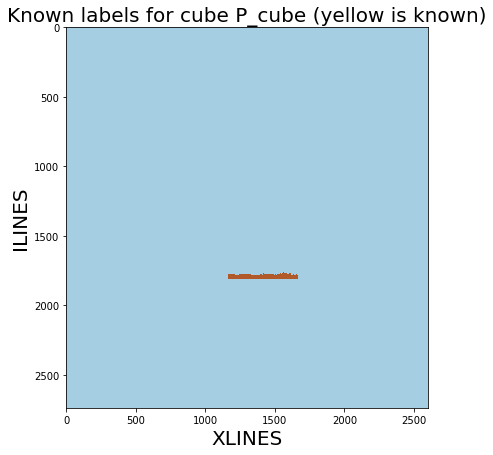

In [61]:
img_res = ds.show_labels(return_image=True, src='predicted_mask_iline')

len  15459


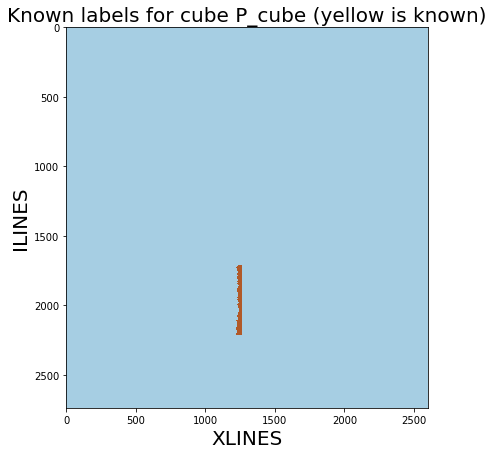

In [238]:
img_res = ds.show_labels(return_image=True, src='predicted_mask_x')